# Is the goal time random ? 

Goal is a rare event in soccer games. The goal time is random in the sense that for a specific game, it is not possible to give any sound prediction on it. However, from a statistical point of view, there should be some pattern for the time distribution of goal time. Is it evenly distributed for every minute, or there is more chance to have a goal in the second half as the defending side is not as energetic as in the first half ? Or maybe the opposite is true, because it is more likely to be an open game in the first half ? 

Let's try to answer these questions using the [Wyscount dataset](https://www.nature.com/articles/s41597-019-0247-7). This is a very valuable dataset made open by Wyscout including spatial and temporal events in matches for the entire 2017-2018 season of the first league in England, Frence, Germany, Italy and Spain, the European Champions League, and the 2018 FIFA World Cup as well.

In [89]:
# load some packages
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import os

from utils import wyscout

In [2]:
# load the dataset from https://figshare.com/collections/Soccer_match_event_dataset/4415000/5
wyscout.download_data()

Download completed


In [3]:
# use the Premier League as an example
dirname = './data/Wyscout/events'
fn = os.path.join(dirname, 'events_England.json')
season = '2017-2018'
league = 'Premier League'

In [4]:
# read in event data using pandas --> DataFrame
df_events = pd.read_json(fn)
df_events.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


In [5]:
# find goal tag
# check the meaning of the tags @https://apidocs.wyscout.com/matches-wyid-events
tag2name = pd.read_csv('./data/Wyscout/tags2name.csv', sep=';')
goal_tag = tag2name[tag2name['Description']=='Goal'].Tag.values[0]
print('Goal event is labelled as tag {}'.format(goal_tag))

Goal event is labelled as tag 101


In [6]:
# add a tag_list column
df_events['tag_list'] = df_events.tags.apply(lambda x: [i['id'] for i in x])

# extract goal events 
goal_events = df_events[df_events.tag_list.apply(lambda x: goal_tag in x)]
goal_events.tail()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tag_list
642749,9,Save attempt,"[{'id': 101}, {'id': 1203}, {'id': 1802}]",10131,"[{'y': 100, 'x': 100}, {'y': 36, 'x': 26}]",2500098,Save attempt,1623,2H,1076.658523,91,251596143,"[101, 1203, 1802]"
642888,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",145692,"[{'y': 55, 'x': 97}, {'y': 100, 'x': 100}]",2500098,Shot,1623,2H,1737.064842,100,251596263,"[101, 402, 201, 1206, 1801]"
642889,9,Reflexes,"[{'id': 101}, {'id': 1206}, {'id': 1802}]",3582,"[{'y': 0, 'x': 0}, {'y': 45, 'x': 3}]",2500098,Save attempt,1633,2H,1739.579587,90,251595998,"[101, 1206, 1802]"
643023,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",41174,"[{'y': 33, 'x': 86}, {'y': 0, 'x': 0}]",2500098,Shot,1633,2H,2193.887080,100,251596096,"[101, 402, 201, 1209, 1801]"
643024,9,Reflexes,"[{'id': 101}, {'id': 1209}, {'id': 1802}]",10131,"[{'y': 100, 'x': 100}, {'y': 67, 'x': 14}]",2500098,Save attempt,1623,2H,2194.459825,90,251596332,"[101, 1209, 1802]"


In [7]:
# note that among these events, there are also Save attempts that need to be excluded
print(goal_events.eventName.unique())
goal_events = goal_events[goal_events.eventName!='Save attempt']

['Shot' 'Save attempt' 'Free Kick']


In [8]:
# Among these goals, some from shots, some from free kicks including penalties
shot_goals = goal_events.groupby('eventName').get_group('Shot')
freekick_goals = goal_events.groupby('eventName').get_group('Free Kick')
print('In total {} goals, {} from shots, {} from free kicks'.format(len(goal_events), len(shot_goals), len(freekick_goals)))

In total 988 goals, 914 from shots, 74 from free kicks


## First or Second Half ?

In [9]:
# separate goals in first and second half time
goal_1H_sec = goal_events[goal_events.matchPeriod=='1H'].eventSec.values
goal_2H_sec = goal_events[goal_events.matchPeriod=='2H'].eventSec.values

# transform from seconds to minutes
goal_1H_min = goal_1H_sec//60
goal_2H_min = goal_2H_sec//60

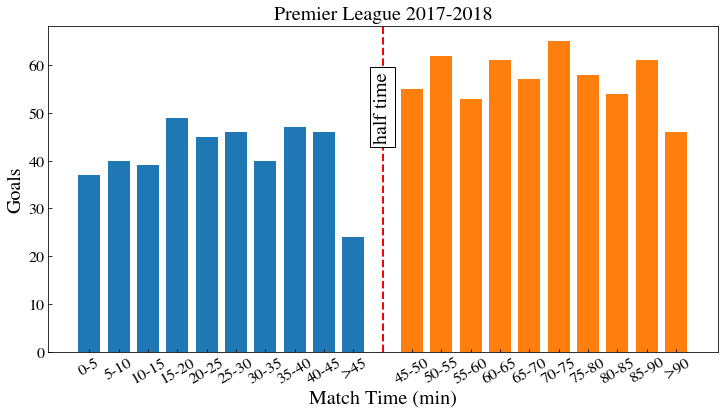

In [10]:
plt.style.use('./utils/default_plot_style.mplstyle')

max_H = int(max([np.max(goal_1H_min), np.max(goal_2H_min)]))
bins_1H = range(0, 51, 5)
bins_2H = range(55, 106, 5)
xticks = range(0, 101, 5)
xticklabels = [str(i)+'-'+str(i+5) for i in range(0, 90, 5)]
xticklabels.insert(9, '>45')
xticklabels.insert(10, '')
xticklabels.append('>90')

fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.hist(goal_1H_min, bins=bins_1H, rwidth=0.75, align='left')
ax.hist(goal_2H_min + 55, bins=bins_2H, rwidth=0.75, align='left')
ax.axvline(x=50, color='r', linestyle='--') # add half time line
ax.text(x=0.5, y=0.75, s='half time', transform=ax.transAxes, ha='center', va='center', rotation=90, fontsize=20, bbox=dict(facecolor='white'))
ax.set_title(league + ' ' + season)
ax.set_xlabel('Match Time (min)')
ax.set_ylabel('Goals')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=30)

plt.show()
fig.savefig('./figs/PL_score_time.png', dpi=300)

In [11]:
n_matches = df_events.groupby('matchId').ngroups
goal_diff_per_match = (len(goal_2H_min) - len(goal_1H_min))/n_matches
goal_ratio = len(goal_2H_min)/len(goal_1H_min) - 1
print('Second half has a {:.2} more goals in average'.format(goal_diff_per_match))
print('Second half has a {:.1%} higher goal probability'.format(goal_ratio))

Second half has a 0.43 more goals in average
Second half has a 39.2% higher goal probability


### Other National Leagues
Goals in the second half clearly outnumber that in the first half. Let us take a look at the other national leagues.

In [12]:
# First, wrap up the steps above into functions
def extract_goal_events(df):
    # make a tag_list
    tag_list = df.tags.apply(lambda x: [i['id'] for i in x])

    # extract goal events
    goal_events = df[tag_list.apply(lambda x: goal_tag in x)] # goal_tag is global

    # exclude save attempt
    goal_events = goal_events[goal_events.eventName!='Save attempt']    

    return goal_events

def plot_scoring_time(goal, time='sec', ax=None, title=None):
    goal_1H = goal[0]
    goal_2H = goal[1]
    if time=='sec':
        # transform from seconds to minutes
        goal_1H = goal_1H//60
        goal_2H = goal_2H//60
    
    max_H = int(max([np.max(goal_1H), np.max(goal_2H)]))
    bins_1H = range(0, 51, 5)
    bins_2H = range(55, 106, 5)
    xticks = range(0, 101, 5)
    xticklabels = [str(i)+'-'+str(i+5) for i in range(0, 90, 5)]
    xticklabels.insert(9, '>45')
    xticklabels.insert(10, '')
    xticklabels.append('>90')

    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(12,6))

    ax.hist(goal_1H, bins=bins_1H, rwidth=0.75, align='left')
    ax.hist(goal_2H + 55, bins=bins_2H, rwidth=0.75, align='left')
    ax.axvline(x=50, color='r', linestyle='--') # add half time line
    ax.text(x=0.5, y=0.75, s='half time', transform=ax.transAxes, ha='center', va='center', rotation=90, fontsize=20, bbox=dict(facecolor='white'))

    ax.set_title(title)
    ax.set_ylabel('Goals')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=30)

    return

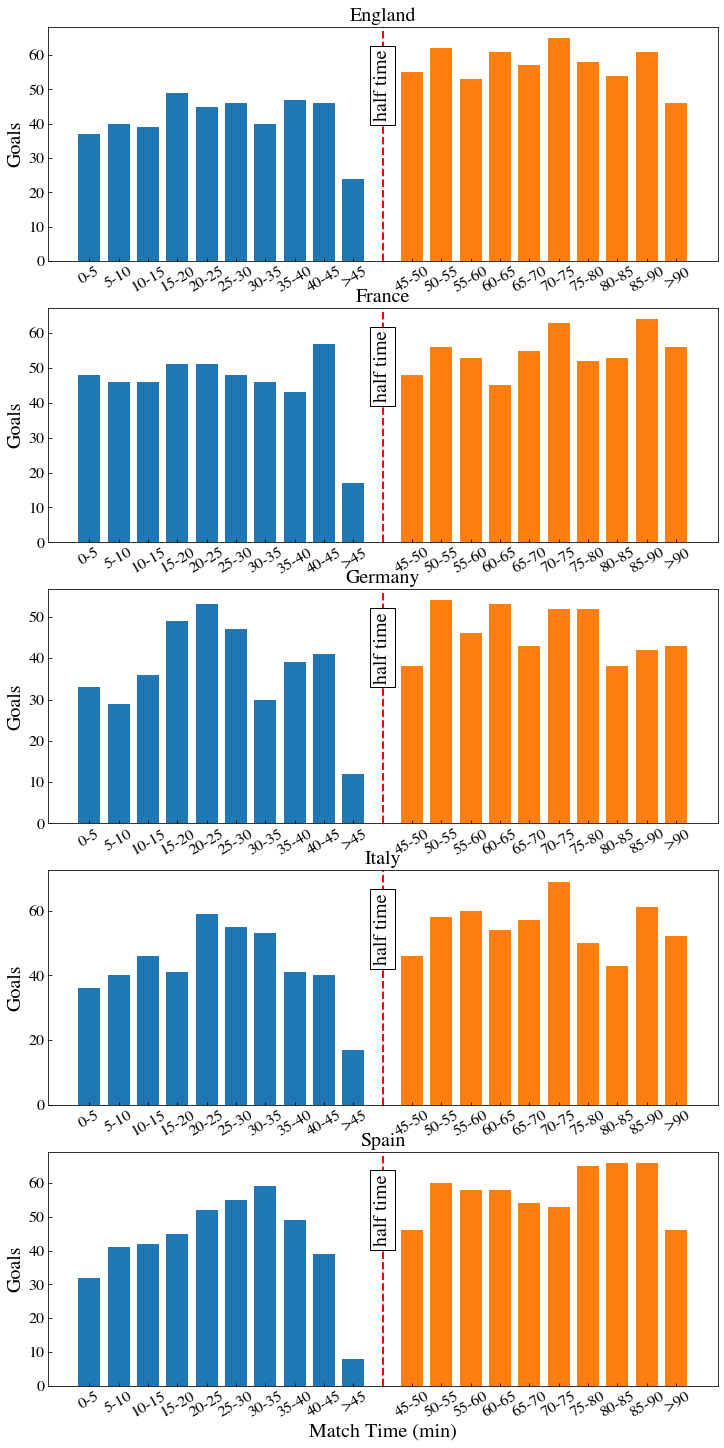

In [13]:
# plot the time distribution of goals for all the five leagues
leagues = ['England', 'France', 'Germany', 'Italy', 'Spain']
goal_time_league = []

fig, axes = plt.subplots(nrows=len(leagues), ncols=1, figsize=(12, len(leagues)*5))

for league, ax in zip(leagues, axes):
    fn = os.path.join(dirname, 'events_'+league+'.json')
    df = pd.read_json(fn)

    goal_events = extract_goal_events(df)
    goal_1H = goal_events[goal_events.matchPeriod=='1H'].eventSec.values
    goal_2H = goal_events[goal_events.matchPeriod=='2H'].eventSec.values
    goal_time_league.append((goal_1H, goal_2H))

    plt.style.use('./utils/default_plot_style.mplstyle')
    plot_scoring_time((goal_1H, goal_2H), ax=ax, title=league)
    
plt.xlabel('Match Time (min)')
plt.show()
fig.savefig('./figs/leagues_scoring_time.png', dpi=300)

In [14]:
for league, (goal_1H, goal_2H) in zip(leagues, goal_time_league):
    n_goal_1H = len(goal_1H)
    n_goal_2H = len(goal_2H)
    a = n_goal_2H/n_goal_1H - 1
    print('{:8} : 1H - {} goals, 2H - {} goals ({:.1%} higher)'.format(league, n_goal_1H, n_goal_2H, a))

England  : 1H - 413 goals, 2H - 575 goals (39.2% higher)
France   : 1H - 453 goals, 2H - 545 goals (20.3% higher)
Germany  : 1H - 370 goals, 2H - 463 goals (25.1% higher)
Italy    : 1H - 429 goals, 2H - 551 goals (28.4% higher)
Spain    : 1H - 422 goals, 2H - 572 goals (35.5% higher)


An interesting observation here is that the English and Spanish leagues have much more second-half goals.

### Home or Away Matters ?

The home tends to attack because they don't want to accept a draw or lose in front of the home fans.

In [101]:
# match information is stored in the matches_[League].json file
match_file = './data/Wyscout/matches/matches_England.json'
# add homeaway feature in the dataframe
events = wyscout.add_event_cols(df_events, ['homeaway'], match_file)

In [103]:
goal = extract_goal_events(events)
goal_home = goal[goal['homeaway']=='home']
goal_away= goal[goal['homeaway']=='away']

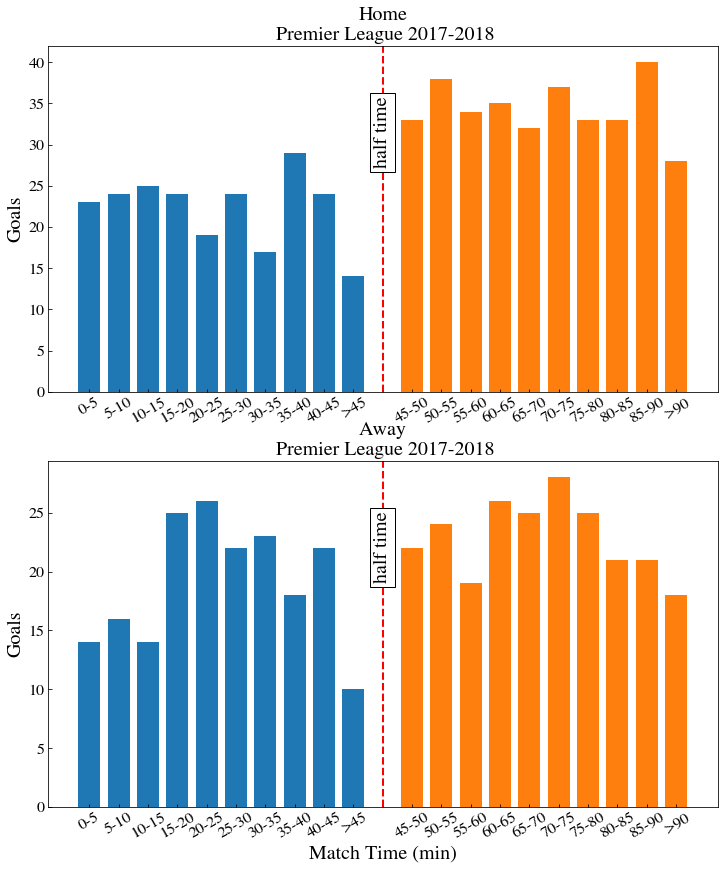

In [113]:
homeaway = ['Home', 'Away']
goal_events = [goal_home, goal_away]
goal_time_ha = []

fig, axes = plt.subplots(nrows=len(homeaway), ncols=1, figsize=(12, 14))

for ha, events, ax in zip(homeaway, goal_events, axes):
    fn = os.path.join(dirname, 'events_'+league+'.json')
    df = pd.read_json(fn)

    goal_1H = events[events.matchPeriod=='1H'].eventSec.values
    goal_2H = events[events.matchPeriod=='2H'].eventSec.values
    goal_time_ha.append((goal_1H, goal_2H))

    plt.style.use('./utils/default_plot_style.mplstyle')
    plot_scoring_time((goal_1H, goal_2H), ax=ax, title=ha+'\n Premier League 2017-2018')
    
plt.xlabel('Match Time (min)')
plt.show()
fig.savefig('./figs/homeaway_scoring_time.png', dpi=300)

In [114]:
for ha, (goal_1H, goal_2H) in zip(homeaway, goal_time_ha):
    n_goal_1H = len(goal_1H)
    n_goal_2H = len(goal_2H)
    a = n_goal_2H/n_goal_1H - 1
    print('{:5} : 1H - {} goals, 2H - {} goals ({:.1%} higher)'.format(ha, n_goal_1H, n_goal_2H, a))

Home  : 1H - 223 goals, 2H - 345 goals (54.7% higher)
Away  : 1H - 190 goals, 2H - 230 goals (21.1% higher)


Clearly, the home team has a much higher probability to score in the second half by a increase of over 50%, while the away team only has 20% increase for a second-half goal.